# Predicting stock market prices

__Data manipulation, feature extraction, prediction and cross-validation of stock market prices time series.__ 

---

> ___If one can model the value of a company as it changes over time, we can make predictions about where that company will be in the future___.

The dataset to be used contains historical company market values over several years. 

We first load the data set. We take the relevant rows and columns, pivot them so the columns correspond to the companies, and transform indices to date-time form.

For the EDA, we only take a few companies: __Apple__, __Amazon__, __FaceBook__, __Google__, __Netflix__, __Visa__.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import KFold, cross_val_score, TimeSeriesSplit
from sklearn.utils import resample
from sklearn.metrics import r2_score

In [2]:
file = pd.read_csv('nyse/prices.csv', index_col=0)[251:][['symbol', 'close']]

# Convert the index of the DataFrame to datetime
file.index = pd.to_datetime(file.index)

# Reshape and select only a few columns
prices = file.pivot(columns='symbol', values='close')[['AAPL', 'AMZN', 'FB', 'GOOGL', 'NFLX', 'V']]

prices.head()

symbol,AAPL,AMZN,FB,GOOGL,NFLX,V
date,,,,,,
2010-01-04,214.009998,133.899994,NaN,626.750011,53.479999,88.139999
2010-01-05,214.379993,134.690002,NaN,623.990017,51.510001,87.129997
2010-01-06,210.969995,132.250000,NaN,608.260035,53.319999,85.959999
2010-01-07,210.580000,130.000000,NaN,594.100015,52.400001,86.760002
2010-01-08,211.980005,133.520004,NaN,602.020005,53.300002,87.000000


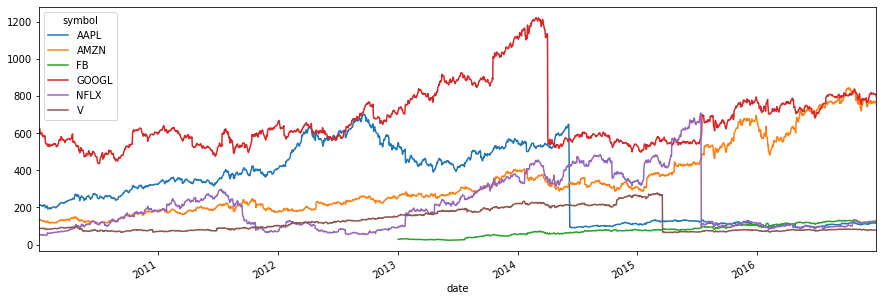

In [3]:
prices.plot(figsize=(15,5))
plt.show()

Note that each company's value is sometimes correlated with others, and sometimes not.

## Cleaning and improving data
---

A common technique to clean data is transforming it so it is more well-behaved. 

#### Smoothing

Here, we will use the rolling window technique: by defining a window around each timepoint, calculating the mean of this window and then repeating this for each timepoint, results in a smoother signal over time. 

Using a rolling window, we will calculate each timepoint's percent change over the mean of a window of previous timepoints. This standarizes the variance of our data and reduces long-term drift. 

For this, we define a function that calculates the percent change of the latest data point from the mean of a window of previous data points. This function will help us calculate the percent change over a rolling window. This is a more stable kind of time series that is often useful in machine learning.

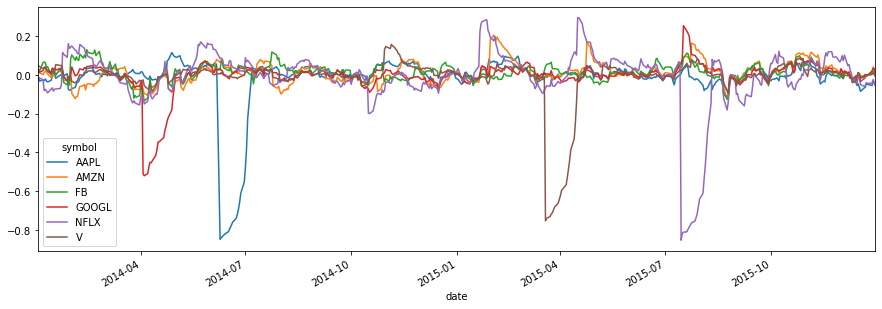

In [4]:
def percent_change(series):
    # Collect all but the last value of this window, then the final value
    
    previous_values = series[:-1]
    last_value = series[-1]

    # Calculate the % difference between the last value and the mean of earlier values
    
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change


prices_perc = prices.rolling(20).agg(percent_change)
prices_perc.loc["2014":"2015"].plot(figsize=(15,5))

This is a cleaner representation of the data.

#### Outliers

We will now handle outliers---data points that are so different from the rest of the data, that we treat them differently from other "normal-looking" data points. We will use the ```prices_perc``` (percent change over time) data to detect the outliers. First we will write a function that replaces outlier data points with the median value from the entire time series.

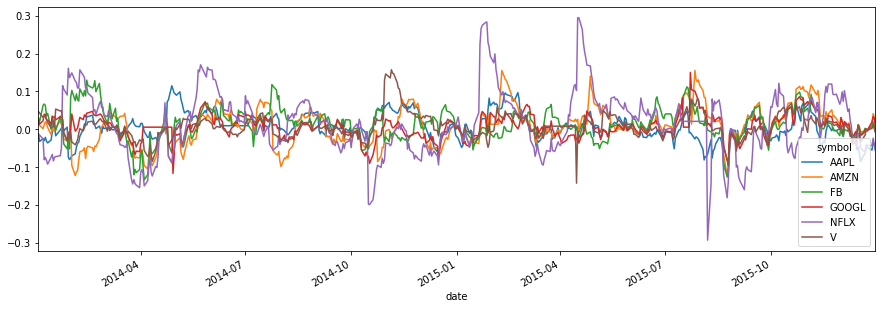

In [5]:
def replace_outliers(series):
    # Calculate the absolute difference of each timepoint from the series mean
    absolute_differences_from_mean = np.abs(series - np.mean(series))

    # Calculate a mask for the differences that are > 3 standard deviations from zero
    this_mask = absolute_differences_from_mean > (np.std(series) * 3)

    # Replace these values with the median accross the data
    series[this_mask] = np.nanmedian(series)
    return series


prices_perc = prices_perc.apply(replace_outliers)
prices_perc.loc["2014":"2015"].plot(figsize=(15,5))

Since we have converted the data to percent change over time, it was easier to spot and correct the outliers.

## Feature engineering
---

There exist some features that are specially useful in timeseries analysis. 

#### Mean, Min, Max, Std

We can extract them using the same rolling window techniques we have already used: we can compute the change of statistical properties such as the mean or the standard deviation of the rolling window over time.

Here, we will calculate a collection of features for a time series data (__Netflix__, for example) and visualize what they look like over time. This process resembles how many other time series models operate.

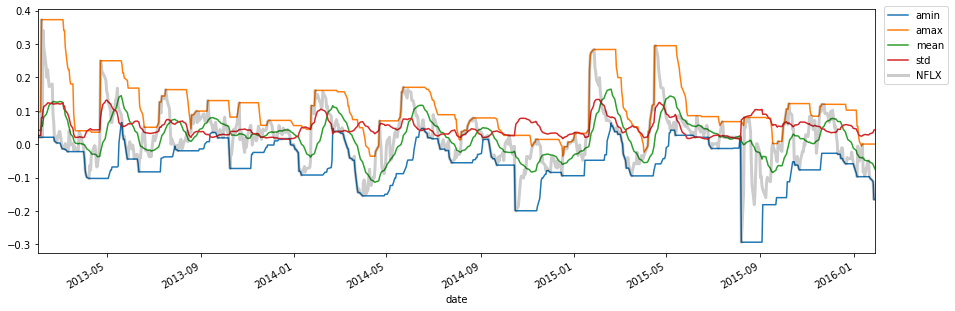

In [6]:
company = 'NFLX'

# Define a rolling window, excluding the right-most datapoint of the window
prices_perc_com = prices_perc[company]

prices_perc_rolling_com = prices_perc_com.rolling(20, min_periods=5, closed='right')

# Define the features we'll calculate for each window
features_to_calculate = [np.min, np.max, np.mean, np.std]

# Calculate these features for your rolling window object
features = prices_perc_rolling_com.agg(features_to_calculate)

# Plot the results
ax = features.loc["2013-02":"2016-01"].plot(figsize=(15,5))
prices_perc_com.loc["2013-02":"2016-01"].plot(ax=ax, color='k', alpha=.2, lw=3)
ax.legend(loc=(1.01, .69))
plt.show()

#### Percentiles

A particularly useful tool for feature extraction is the percentile function---it gives us more fine-grained control over what is extracted. For a given dataset, the Nth percentile is the value where N% of the data is below that datapoint, and 100-N% of the data is above that datapoint. 

We will combine the percentile function with partial functions in order to extract several percentiles with the ```.aggregate()``` method. We use a list comprehension to create a list of functions. Then, we loop through the list, calling each function on our data, to return a different percentile of the data. We could pass this list of partial functions to our ```.aggregate()``` to extract several percentiles for each column.

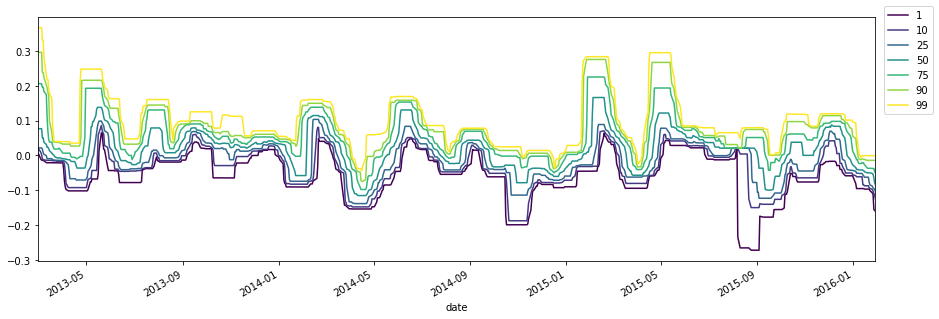

In [7]:
percentiles = [1, 10, 25, 50, 75, 90, 99]

# Use a list comprehension to create a partial function for each quantile
percentile_functions = [partial(np.percentile, q=percentile) for percentile in percentiles]

# Calculate each of these quantiles on the data using a rolling window
features_percentiles = prices_perc_rolling_com.agg(percentile_functions)
features_percentiles.columns = ['perc_{}%'.format(i) for i in percentiles]

# Plot a subset of the result
ax = features_percentiles.loc["2013-03":"2016-01"].plot(cmap=plt.cm.viridis, figsize=(15,5))
ax.legend(percentiles, loc=(1.01, .6))
plt.show()

#### Date-based features

It is easy to think of timestamps as pure numbers, but let's not forget they generally correspond to things that happen in the real world. That means there is often extra information encoded in the data such as "is it a weekday?" or "is it a holiday?". This information is often useful in predicting timeseries data.

In [8]:
prices_perc_com = prices_perc_com.to_frame()

# Extract date features from the data, add them as columns
prices_perc_com['day_of_week'] = prices_perc_com.index.weekday
prices_perc_com['week_of_year'] = prices_perc_com.index.week
prices_perc_com['month_of_year'] = prices_perc_com.index.month

prices_perc_com.tail()

,NFLX,day_of_week,week_of_year,month_of_year
date,,,,
2016-12-23,0.025608,4,51,12
2016-12-27,0.044260,1,52,12
2016-12-28,0.019513,2,52,12
2016-12-29,0.011146,3,52,12
2016-12-30,-0.004625,4,52,12


### Joining features

We create a dataset containeng all the features we just created.

In [9]:
nflx_features = pd.concat([prices_perc_com, features, features_percentiles], axis=1)
nflx_features.tail()

,NFLX,day_of_week,week_of_year,month_of_year,amin,amax,mean,std,perc_1%,perc_10%,perc_25%,perc_50%,perc_75%,perc_90%,perc_99%
date,,,,,,,,,,,,,,,
2016-12-23,0.025608,4,51,12,-0.016738,0.068781,0.028850,0.023473,-0.015484,-0.008552,0.022536,0.033312,0.041839,0.050245,0.067474
2016-12-27,0.044260,1,52,12,-0.010135,0.068781,0.031900,0.021078,-0.009801,-0.006156,0.026495,0.036117,0.042539,0.050245,0.067474
2016-12-28,0.019513,2,52,12,-0.010135,0.068781,0.033295,0.019103,-0.009332,0.011397,0.026495,0.036117,0.042539,0.050245,0.067474
2016-12-29,0.011146,3,52,12,-0.005910,0.068781,0.034359,0.017038,-0.002669,0.013102,0.026495,0.036117,0.042539,0.050245,0.067474
2016-12-30,-0.004625,4,52,12,-0.004625,0.068781,0.034423,0.016880,-0.001629,0.013102,0.026495,0.036117,0.042539,0.050245,0.067474


### Auto-regressive features

We will "shift" the raw data and visualize the results. We will use the percent change time series, this time with a very short window. A short window is important because, in a real-world scenario, we want to predict the day-to-day fluctuations of a time series, not its change over a longer window of time.

We will focus on only one company for simplicity but the same analysis can be performed for data of several companies at once.

In [10]:
company = 'NFLX'

# prices_perc = prices.rolling(20).agg(percent_change)[company]

# These are the "time lags"
shifts = np.arange(1, 11).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift): prices_perc_com.iloc[:,0].shift(day_shift) 
                for day_shift in shifts}

# Convert into a DataFrame for subsequent use
prices_perc_shifted = pd.DataFrame(shifted_data)

prices_perc_shifted.tail()

,lag_1_day,lag_2_day,lag_3_day,lag_4_day,lag_5_day,lag_6_day,lag_7_day,lag_8_day,lag_9_day,lag_10_day
date,,,,,,,,,,
2016-12-23,0.029140,0.040634,0.032446,0.038548,0.032418,0.043452,0.034178,0.041707,0.038057,0.042235
2016-12-27,0.025608,0.029140,0.040634,0.032446,0.038548,0.032418,0.043452,0.034178,0.041707,0.038057
2016-12-28,0.044260,0.025608,0.029140,0.040634,0.032446,0.038548,0.032418,0.043452,0.034178,0.041707
2016-12-29,0.019513,0.044260,0.025608,0.029140,0.040634,0.032446,0.038548,0.032418,0.043452,0.034178
2016-12-30,0.011146,0.019513,0.044260,0.025608,0.029140,0.040634,0.032446,0.038548,0.032418,0.043452


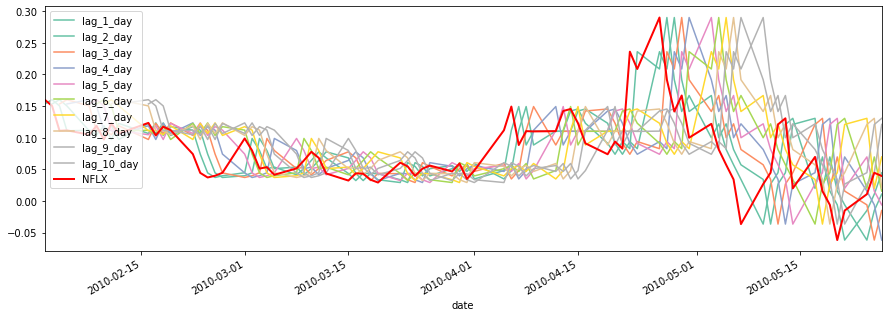

In [11]:
# Plot the first 100 samples
ax = prices_perc_shifted.iloc[20:100].plot(cmap=plt.cm.Set2, figsize=(15,5))
prices_perc_com.iloc[20:100,0].plot(color='r', lw=2)
ax.legend(loc='best')
plt.show()

## Predicting (Auto-regressive)
---
Now we can fit an auto-regressive model. This is a regression model where the input features are time-shifted versions of the output time series data. We are using previous values of a timeseries to predict current values of the same timeseries (thus, it is auto-regressive).

By investigating the coefficients of this model, you can explore any repetitive patterns that exist in a timeseries, and get an idea for how far in the past a data point is predictive of the future.

We fill in the missing values with the median so that it behaves well with scikit-learn.

In [12]:
# Replace missing values with the median for each column
X_auto = prices_perc_shifted.fillna(np.nanmedian(prices_perc_shifted))
y_auto = prices_perc_com.iloc[:,0].fillna(np.nanmedian(prices_perc_com.iloc[:,0]))

# Fit the model
model_auto = Ridge()
model_auto.fit(X_auto, y_auto)

predict_auto = model_auto.predict(X_auto)
y_pred_auto = pd.DataFrame(predict_auto, columns=['pred_auto'], index=y_auto.index)

#### Model's coefficients

Let's visualize the model coefficients. This is an important part of machine learning because it gives us an idea for how the different features of a model affect the outcome. 

We will create a function that, given a set of coefficients and feature names, visualizes the coefficient values.

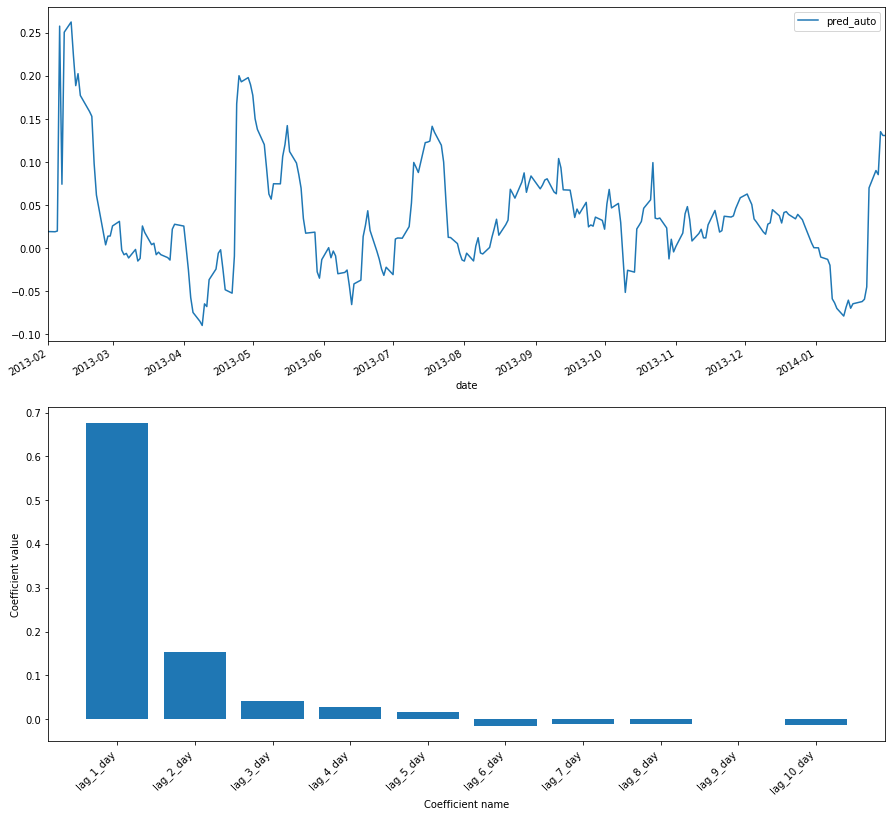

In [13]:
def visualize_coefficients(coefs, names, ax):
    # Make a bar plot for the coefficients, including their names on the x-axis
    ax.bar(names, coefs)
    ax.set(xlabel='Coefficient name', ylabel='Coefficient value')

    # Set formatting so it looks nice
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    return ax


# Visualize the output data for one year
fig, axs = plt.subplots(2, 1, figsize=(15, 15))
y_pred_auto.loc['2013-02':'2014-01'].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model_auto.coef_, prices_perc_shifted.columns, ax=axs[1])
plt.show()

__Large absolute values of coefficients mean that a given feature has a large impact on the output variable.__

When we use time-lagged features on the raw data, we see that the highest coefficient by far is the first one. This means that the N-1th time point is useful in predicting the Nth timepoint, but no other points are useful.

Re-running the same procedure using a smoother signal, this time using a much larger window (40 instead of 20), would make that the difference between neighboring timepoints gets smaller, resulting in a smoother signal.

As we can see here, by transforming the data with a larger window, we have also changed the relationship between each timepoint and the ones that come just before it. These model's coefficients gradually go down to zero, which means that the signal itself is smoother over time.

## Predicting (fetureful dataset)
---

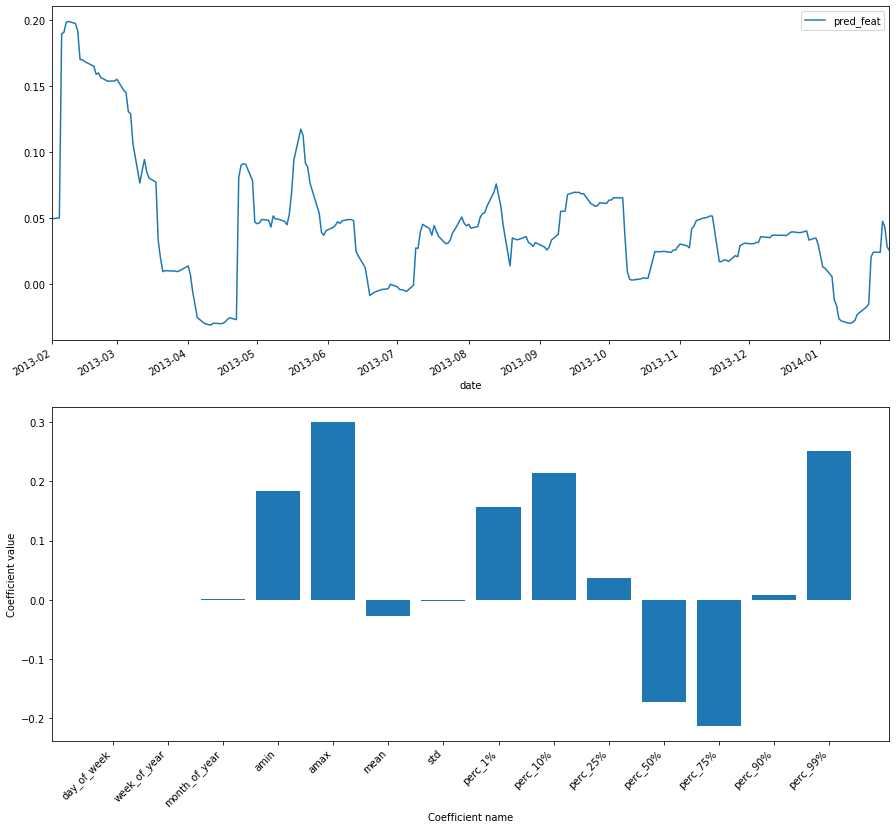

In [14]:
# Replace missing values with the median for each column
X_feat = nflx_features.iloc[:,1:].fillna(np.nanmedian(nflx_features.iloc[:,1:]))
y_feat = nflx_features.iloc[:,0].fillna(np.nanmedian(nflx_features.iloc[:,0]))

# Fit the model
model_feat = Ridge()
model_feat.fit(X_feat, y_feat)

predict_feat = model_feat.predict(X_feat)
y_pred_feat = pd.DataFrame(predict_feat, columns=['pred_feat'], index=y_feat.index)

# Visualize the output data for one year
fig, axs = plt.subplots(2, 1, figsize=(15, 15))
y_pred_feat.loc['2013-02':'2014-01'].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model_feat.coef_, nflx_features.iloc[:,1:].columns, ax=axs[1])
plt.show()

#### Both

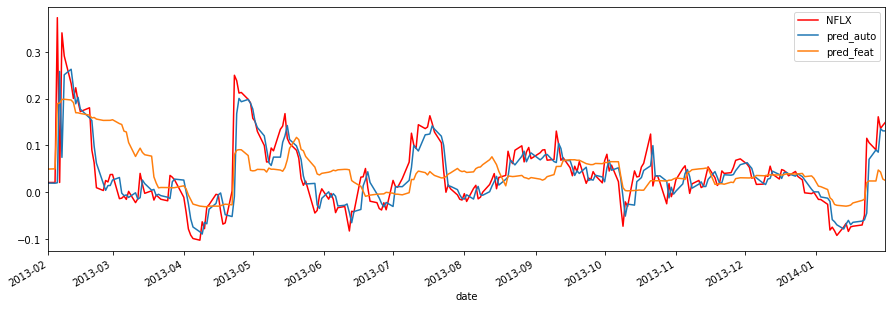

In [15]:
axs = plt.gca()
y_auto.to_frame().loc['2013-02':'2014-01'].plot(ax = axs, label='y_set', color='r', figsize=(15,5))
y_pred_auto.loc['2013-02':'2014-01'].plot(ax = axs)
y_pred_feat.loc['2013-02':'2014-01'].plot(ax = axs)
plt.show()

## Cross-Validation
---

#### K-Fold
The most common form of cross-validation is k-fold cross-validation. In this case, data is split into _k_ subsets of equal size. In each iteration, a single subset is left out as the validation set.

Many cross-validation iterators let you randomly shuffle the data. This may be appropriate if your data is independent and identically distributed, but time series data is usually not _i.i.d._ If the data is shuffled, it means that some information about the training set now exists in the validation set, and you can no longer trust the score of your model.

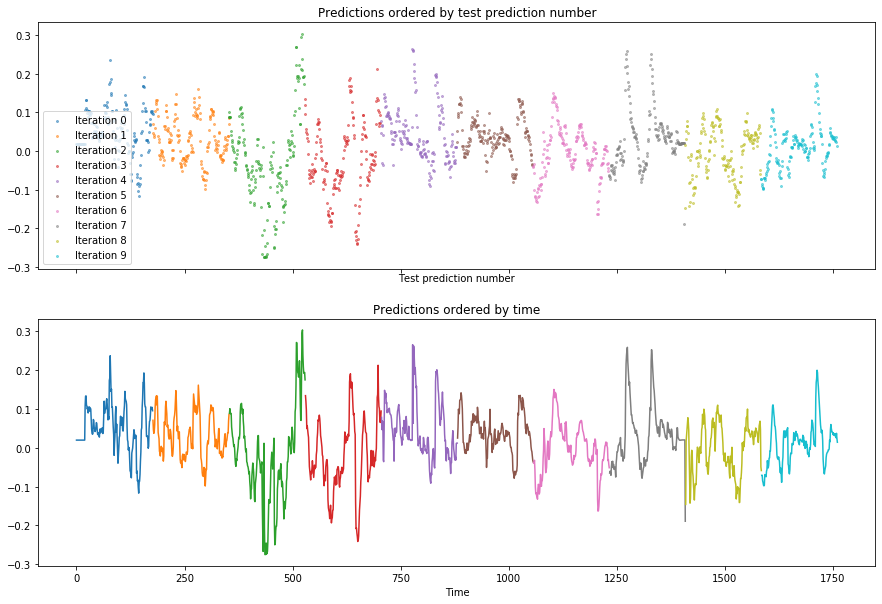

In [16]:
def visualize_predictions(results):
    fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    
    # Loop through our model results to visualize them
    for ii, (prediction, score, indices) in enumerate(results):
        # Plot the predictions of the model in the order they were generated
        offset = len(prediction) * ii
        axs[0].scatter(np.arange(len(prediction)) + offset, prediction,
                       alpha=0.5, s=4, label='Iteration {}'.format(ii))
        
        # Plot the predictions of the model according to how time was ordered
        axs[1].plot(indices, prediction)
    axs[0].legend(loc="best")
    axs[0].set(xlabel="Test prediction number", title="Predictions ordered by test prediction number")
    axs[1].set(xlabel="Time", title="Predictions ordered by time")
    # plt.savefig('plot.png')
    plt.show()


cv = KFold(n_splits=10, shuffle=False, random_state=1)

# Iterate through CV splits
results_kf = []

for tr, tt in cv.split(X_auto.values, y_auto):
    # Fit the model on training data
    model_auto.fit(X_auto.values[tr], y_auto[tr])
    
    # Generate predictions on the test data and collect
    prediction = model_auto.predict(X_auto.values[tt])
    score = r2_score(y_auto[tt], prediction)
    results_kf.append((prediction, score, tt))
    
# Custom function to quickly visualize predictions
visualize_predictions(results_kf)

In [17]:
print('K-Fold CV mean score: {}'.format(round(np.mean([results_kf[i][1] 
                                                       for i in range(len(results_kf))]),2)))

K-Fold CV mean score: 0.76


#### TimeSeriesSplit

There is another cross-validations technique that is meant particularly for time series data. ```TimeSeriesSplit``` always uses data from the past to predict timepoints in the future. Through CV iterations, a larger amount of training data is used to predict the next block of validation data, corresponding to the fact that more time has passed. This more closely mimics the data collection and predictions process in the real world.

In the following plots we see how the TimeSeriesSplit CV object behaves---we iterate through the object and plot the training data in blue and the validation data in red. Each row is an iteration of the cross_validation. In red we see the indices for that iteration. As one can see, the training data always comes before the validation data. This ensures that only the past is always used to predict the future.

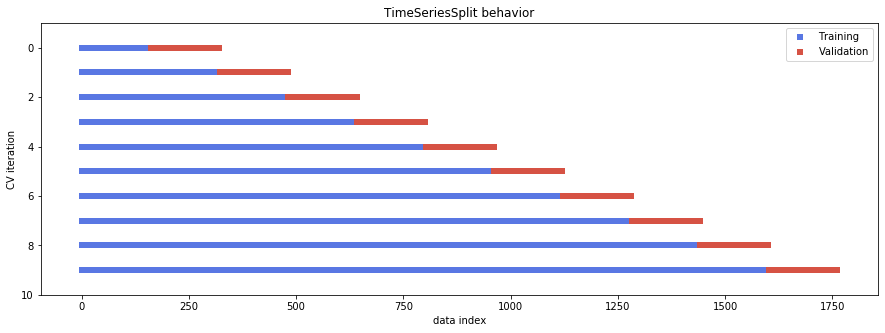

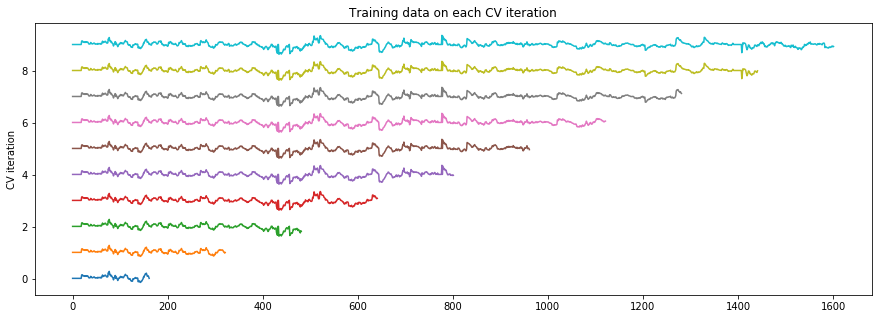

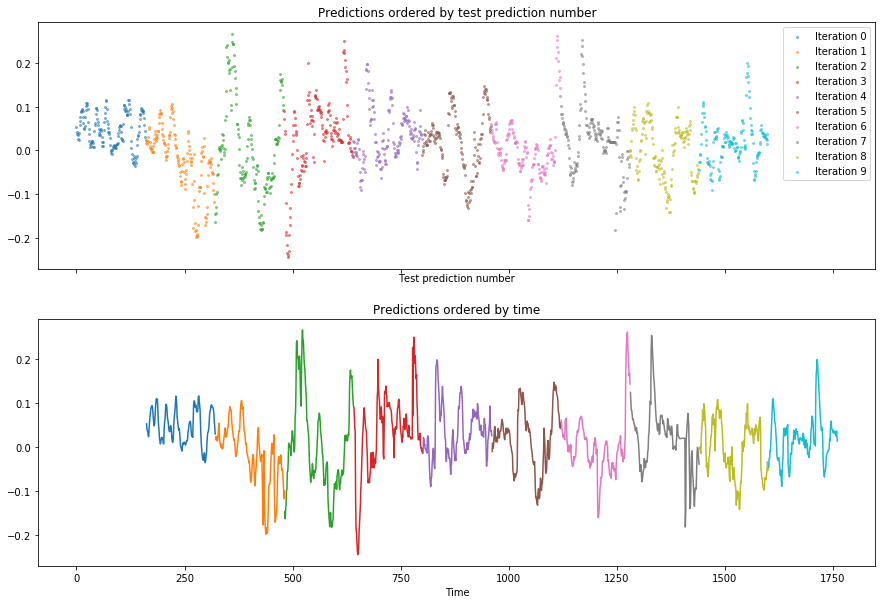

In [18]:
# Import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

# Create time-series cross-validation object
cv = TimeSeriesSplit(n_splits=10)

fig, ax = plt.subplots(figsize=(15, 5))
for ii, (tr, tt) in enumerate(cv.split(X_auto, y_auto)):
    # Plot training and test indices
    l1 = ax.scatter(tr, [ii] * len(tr), c=[plt.cm.coolwarm(.1)], marker='_', lw=6)
    l2 = ax.scatter(tt, [ii] * len(tt), c=[plt.cm.coolwarm(.9)], marker='_', lw=6)
    ax.set(ylim=[10, -1], title='TimeSeriesSplit behavior', xlabel='data index', ylabel='CV iteration')
    ax.legend([l1, l2], ['Training', 'Validation'])

# Iterate through CV splits
fig, ax = plt.subplots(figsize=(15,5))
for ii, (tr, tt) in enumerate(cv.split(X_auto, y_auto)):
    # Plot the training data on each iteration, to see the behavior of the CV
    ax.plot(tr, ii + y_auto[tr])
ax.set(title='Training data on each CV iteration', ylabel='CV iteration')

# Iterate through CV splits
results_ts = []

for tr, tt in cv.split(X_auto.values, y_auto):
    # Fit the model on training data
    model_auto.fit(X_auto.values[tr], y_auto[tr])
    
    # Generate predictions on the test data and collect
    prediction = model_auto.predict(X_auto.values[tt])
    score = r2_score(y_auto[tt], prediction)
    results_ts.append((prediction, score, tt))
    
# Custom function to quickly visualize predictions
visualize_predictions(results_ts)

plt.show()

In [19]:
print('TimeSeriesSplit CV mean score: {}'.format(round(np.mean([results_ts[i][1] 
                                                                for i in range(len(results_ts))]),2)))

TimeSeriesSplit CV mean score: 0.74


## Stationarity and stability
---

A stationary signal is one that does not change its statistical properties over time. Whether a signal is stationary or not has important implications on how to fit models.

Furthermore, most models have an implicit assumption that the relationship between inputs and outputs is static. If this relationships changes (because the data is not stationary) then the model will generate predictions using an outdated relationship between inputs and outputs.

One approach to quantify and correct for this is to use cross-validation, which yields a set of model coefficients per iteration. We can quantify the variability of these coefficients across iterations. If a model's coefficients vary widely between cross-validation splits, there is a good change that the data is non-stationary (or noisy).

Bootstrapping is a way to estimate the confidence in the mean of a collection of numbers. We use the resample function in scikit-learn to take a random sample of coefficients, then use numpy to calculate the mean for each coefficient in the sample and store it in an array. Then, we calculate the 2.5 and 97.5 percentile of the results to calculate lower and upper bounds for each coefficient.

In [20]:
def bootstrap_interval(data, percentiles=(2.5, 97.5), n_boots=100):
    """Bootstrap a confidence interval for the mean of columns of a 1- or 2-D dataset."""
    # Create the empty array we'll fille with the results
    if data.ndim == 1:
        data = data[:, np.newaxis]
    data = np.atleast_2d(data)
    bootstrap_means = np.zeros([n_boots, data.shape[-1]])
    for ii in range(n_boots):
        # Generate random indices for our data with replacement, then take the sample mean
        random_sample = resample(data)
        bootstrap_means[ii] = random_sample.mean(axis=0)

    # Compute the percentiles of choice for the bootstrapped means
    percentiles = np.percentile(bootstrap_means, percentiles, axis=0)
    return percentiles

We will re-run the regression routine used before, but this time paying attention to the model's stability over time. We will investigate the coefficients of the model, as well as the uncertainty in its predictions. 

We begin by assessing the __stability (or uncertainty) of a model's coefficients__ across multiple CV splits. Remember, the coefficients are a reflection of the pattern that your model has found in the data. 

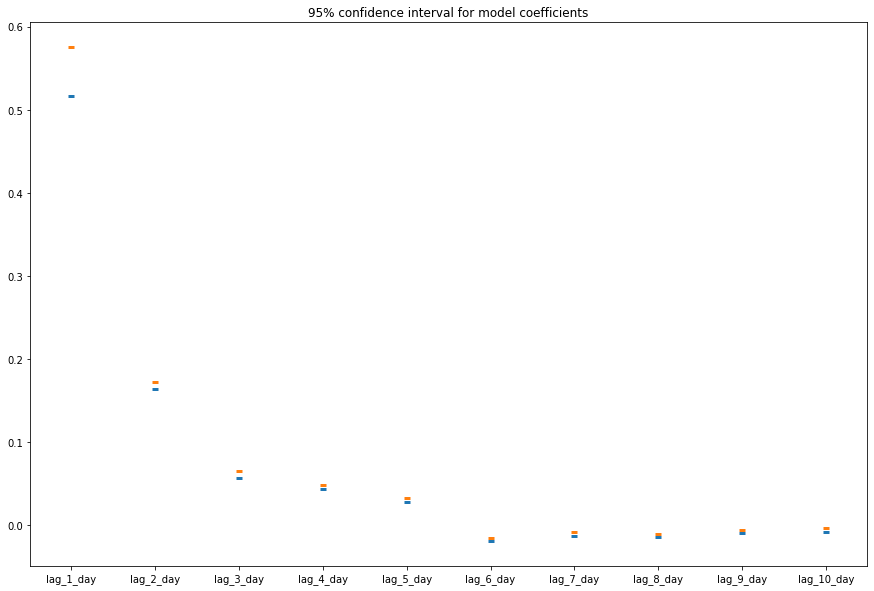

In [21]:
model = model_auto
X = X_auto
y = y_auto

# Iterate through CV splits
n_splits = 100
cv = TimeSeriesSplit(n_splits)
    
feature_names = X.columns
times_scores = [X.index[tt[0]] for tr, tt in cv.split(X, y)]

X, y = X.values, y.values

# Create empty array to collect coefficients
coefficients = np.zeros([n_splits, X.shape[1]])
    
for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Fit the model on training data and collect the coefficients
    model.fit(X[tr], y[tr])
    coefficients[ii] = model.coef_

# Calculate a confidence interval around each coefficient
bootstrapped_interval = bootstrap_interval(coefficients)

# Plot it
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(feature_names, bootstrapped_interval[0], marker='_', lw=3)
ax.scatter(feature_names, bootstrapped_interval[1], marker='_', lw=3)
ax.set(title='95% confidence interval for model coefficients')
plt.show()

The plot gives us an idea of the variability across all cross-validation iterations

---
#### Model score variability over time
It is also common to quantify the __stability of a model's predictive power__ across cross-validation folds. 

The ```TimeSeriesSplit``` object will use successively-later indices for each test set. This means that we can treat the scores of our validation as a time series. We can visualize this over time in order to see how the model's performance changes over time.

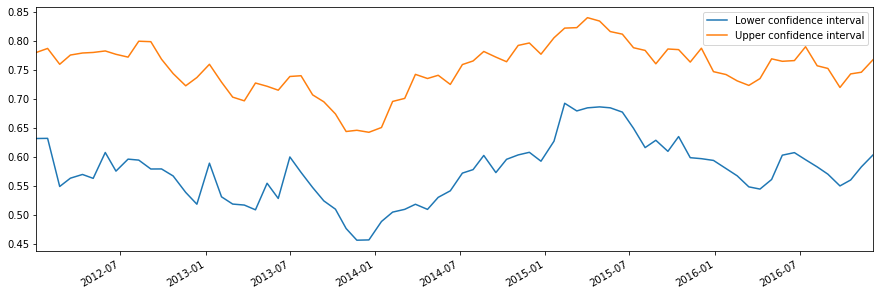

In [22]:
def my_pearsonr(est, X, y):
    return np.corrcoef(est.predict(X).squeeze(), y.squeeze())[1, 0]

# Generate scores for each split to see how the model performs over time
scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)

# Convert to a Pandas Series object
scores_series = pd.Series(scores, index=times_scores, name='score')

# Bootstrap a rolling confidence interval for the mean score
scores_lo = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=2.5))
scores_hi = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=97.5))

# Plot the results
fig, ax = plt.subplots(figsize=(15,5))
scores_lo.loc['2012-01':].plot(ax=ax, label="Lower confidence interval")
scores_hi.loc['2012-01':].plot(ax=ax, label="Upper confidence interval")
ax.legend()
plt.show()

We plotted a rolling confidence interval for scores over time. This is useful in seeing when your model predictions are correct. 

For instance, a low performance can probably happen because the statistics of the data changed. To account for this, one option is to restrict the size of the training window. This ensures that only the latests datapoints are used in training. We can control this with the ```max_train_size``` parameter.

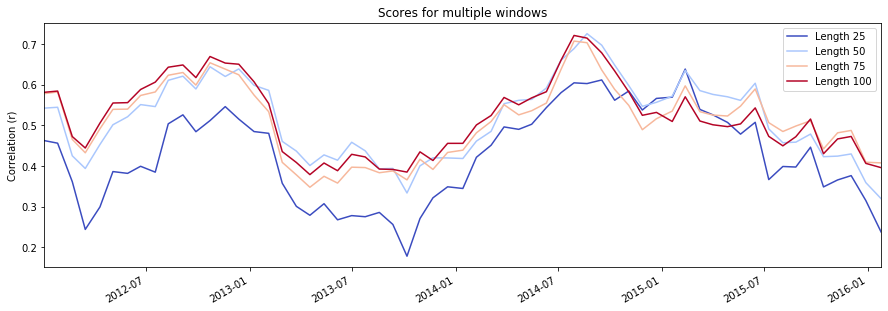

In [23]:
# Pre-initialize window sizes
window_sizes = [25, 50, 75, 100]

# Create an empty DataFrame to collect the stores
all_scores = pd.DataFrame(index=times_scores)

# Generate scores for each split to see how the model performs over time
for window in window_sizes:
    # Create cross-validation object using a limited lookback window
    cv = TimeSeriesSplit(n_splits=100, max_train_size=window)

    # Calculate scores across all CV splits and collect them in a DataFrame
    this_scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)
    all_scores['Length {}'.format(window)] = this_scores

# Visualize the scores
ax = all_scores.rolling(10).mean().loc['2012-01':'2016-01'].plot(cmap=plt.cm.coolwarm, figsize=(15,5))
ax.set(title='Scores for multiple windows', ylabel='Correlation (r)')
plt.show()

Notice how in some stretches of time, longer windows perform worse than shorter ones. This is because the statistics in the data have changed, and the longer window is now using outdated information.

## Conclusions
---

We followed a thorough analysis of stock market time series:

* We transformed the series to percent changes, which results in a smoother signal with the same statistical features.
* With this series, it is simpler to spot outliers and, therefore, remove them.
* We produced a bunch of time series features: statistical features and time-lagged features.
* The latter are used to train _auto-regressive_ models which are known to perform fairly well as we showed.
* For a simple linear model, the _lag_1__day feature is clearly the most important one. This regukarly happens for smooth signals.
* On the other hand, the statistical features are not very useful in predicting this kind of series according to the model's coefficients.
* We checked the models performance under K-Fold and TimeSeriesSplit cross-validations. Both give similar results.
* We finally studied the stability of the model's coefficients and of the scores across CV splits. A large training window gives a better performance.